In [41]:
import pandas as pd
import openpyxl
import os
import numpy as np
import pattern
from pattern.text.en import singularize
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import wordcloud
from wordcloud import WordCloud
from wordcloud import WordCloud,ImageColorGenerator
import matplotlib.pyplot as plt
import re

In [3]:
path='../data/'

In [35]:
data=pd.read_excel(path+'published-research-reports.xlsx',sheet_name=0,engine='openpyxl',usecols='A:G')
data.head()

,Report / note number,Published Date,Theme,Researcher,Research report title,Key words,Available at:
0,RR 681,2021-10-01 00:00:00,Resilience and security,Abley Ltd,Framework for evacuation routes,"evacuation, hazard, lifeline, resilience, risk...",www.nzta.govt.nz/resources/research/reports/681
1,RR 680,2021-09-01 00:00:00,Economic prosperity,NERA Economic Consulting Ltd,Dynamic clustering and transport appraisal,"best practice, cost–benefit analysis, dynamic ...",www.nzta.govt.nz/resources/research/reports/680
2,RR 679,2021-09-01 00:00:00,Environmental sustainability,WSP New Zealand,The reuse of end-of-life tyres to enhance the ...,"bitumen, chipseals, crumb rubber, end-of-life ...",www.nzta.govt.nz/resources/research/reports/679
3,RR 678,2021-08-01 00:00:00,Inclusive access,Mackie Research Ltd,Impacts of a public sector e-bike scheme: Fina...,"e-bikes, purchase support schemes, mode shift,...",www.nzta.govt.nz/resources/research/reports/678
4,RR 677,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
lst_key_words=data['Key words'].str.replace(";",',',regex=True).str.split(", ").to_list()
lst_key_words

[['evacuation',
  'hazard',
  'lifeline',
  'resilience',
  'risk',
  'route',
  'vulnerability'],
 ['best practice',
  'cost–benefit analysis',
  'dynamic agglomeration',
  'dynamic clustering',
  'economic appraisal',
  'economic impact analysis',
  'transport intervention',
  'welfare impacts'],
 ['bitumen', 'chipseals', 'crumb rubber', 'end-of-life tyres', 'modification'],
 ['e-bikes',
  'purchase support schemes',
  'mode shift',
  'incentives',
  'process evaluation'],
 nan,
 ['greenhouse gas',
  'emissions',
  'transport',
  'vehicle kilometres travelled',
  'measurement',
  'mode shift'],
 ['behaviour', 'cycling', 'latent demand', 'methods', 'model', 'walking'],
 ['transport',
  'mental health',
  'cities',
  'quality of life',
  'tāngata whaiora'],
 ['e-bike',
  'e-scooter',
  'first/last mile',
  'micromobility',
  'mode share',
  'mode shift',
  'shared mobility',
  'sustainable transportation'],
 ['construction',
  'ecology',
  'environmental impact',
  'erosion control',
 

### 2. Create edges table

In [75]:
df=data.copy()
df['label']=lst_key_words

In [76]:
df=df.explode('label')
df.dropna(subset={'label'},inplace=True)
df.head()

,Report / note number,Published Date,Theme,Researcher,Research report title,Key words,Available at:,label
0,RR 681,2021-10-01 00:00:00,Resilience and security,Abley Ltd,Framework for evacuation routes,"evacuation, hazard, lifeline, resilience, risk...",www.nzta.govt.nz/resources/research/reports/681,evacuation
0,RR 681,2021-10-01 00:00:00,Resilience and security,Abley Ltd,Framework for evacuation routes,"evacuation, hazard, lifeline, resilience, risk...",www.nzta.govt.nz/resources/research/reports/681,hazard
0,RR 681,2021-10-01 00:00:00,Resilience and security,Abley Ltd,Framework for evacuation routes,"evacuation, hazard, lifeline, resilience, risk...",www.nzta.govt.nz/resources/research/reports/681,lifeline
0,RR 681,2021-10-01 00:00:00,Resilience and security,Abley Ltd,Framework for evacuation routes,"evacuation, hazard, lifeline, resilience, risk...",www.nzta.govt.nz/resources/research/reports/681,resilience
0,RR 681,2021-10-01 00:00:00,Resilience and security,Abley Ltd,Framework for evacuation routes,"evacuation, hazard, lifeline, resilience, risk...",www.nzta.govt.nz/resources/research/reports/681,risk


In [77]:
# get rid of parentheses
df['new_label']=df['label'].str.replace(r"\(.*\)","")
df['new_label']=df['new_label'].str.replace('&'," ")
df['new_label']=df['new_label'].str.replace(':'," ")
#df['new_label']=df['new_label'].str.replace('/'," ")
#df['new_label']=df['new_label'].str.replace('and',"")
df['new_label']=[re.sub(r"\band\b", "", string) for string in df['new_label']]
df['new_label']=df['new_label'].replace('\s+', ' ', regex=True)


<ipython-input-77-ce9b3e81a9d3>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['new_label']=df['label'].str.replace(r"\(.*\)","")


In [78]:
#Manual convert words
df['new_label']=df['new_label'].str.replace('Nz Transport Agency','NZTA')
df['new_label']=df['new_label'].str.replace('annual average daily traffic','AADT')
df['new_label']=df['new_label'].str.replace('greenhouse gas emission','greenhouse gas')
df['new_label']=df['new_label'].str.replace('emission greenhouse','greenhouse gas')
df['new_label']=df['new_label'].str.replace('aged','age')
df['new_label']=df['new_label'].str.replace('ageing','age')
df['new_label']=df['new_label'].str.replace('Waka Kotahi NZ Transport Agency','NZTA')

In [79]:
# decapitalize the key words
def decapitalize(str):
    if str.isupper() == False:
        return str[:1].lower() + str[1:]
    else:
        return str
df['new_label']=[decapitalize(string) for string in df['new_label']]

In [80]:
def singularization(str):
    if str.isupper() == False:
        return singularize(str)
    else:
        return str
    
df['new_label']=[singularization(plural) for plural in df['new_label']]
df['new_label']=df['new_label'].str.lower()

In [81]:
# manual classification
df['new_label']=df['new_label'].str.replace('emission greenhouse','greenhouse gas')
conditions=[df['new_label'].str.contains('behavioural'),
           df['new_label'].str.contains('behaviour'),
           df['new_label'].str.contains('bicycle'),
           df['new_label'].str.contains('bike'),
           df['new_label'].str.contains('bus'),
           df['new_label'].str.contains('accident'),
           df['new_label'].str.contains('asphalt'),
           df['new_label'].str.contains('bitumen'),
           df['new_label'].str.contains('bridge'),]
values=['behavimy','behavimy','bike','bike','bus','accident','asphalt','bitumen','bridge']
df['new_label'] = np.select(conditions, values, default=df['new_label'])

In [82]:
df.to_excel(path+'summary.xlsx',index=False)

### wordcloud

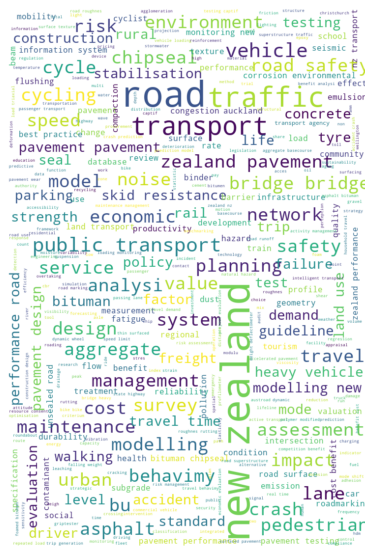

In [98]:
excel_file = df['new_label']
excel_file.to_csv('key_words.txt', sep='\t', index=False)
#coding=utf-8
#read a txt file
text = open('key_words.txt', "r",encoding="utf8").read()
from PIL import Image
#load background picture
char_mask=np.array(Image.open(path+"new.png"))
image_colors = ImageColorGenerator(char_mask)
my_wordcloud = WordCloud(scale=4,background_color='white',mask=char_mask,
                         max_words = 500,max_font_size = 20,random_state=20,min_font_size=1.5).generate(text) 

#show picture
plt.figure(figsize=(20,10))
plt.imshow(my_wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()
my_wordcloud.to_file(path+'key_words.jpg')

### create node table

In [99]:
df.head()

,Report / note number,Published Date,Theme,Researcher,Research report title,Key words,Available at:,label,new_label
0,RR 681,2021-10-01 00:00:00,Resilience and security,Abley Ltd,Framework for evacuation routes,"evacuation, hazard, lifeline, resilience, risk...",www.nzta.govt.nz/resources/research/reports/681,evacuation,evacuation
0,RR 681,2021-10-01 00:00:00,Resilience and security,Abley Ltd,Framework for evacuation routes,"evacuation, hazard, lifeline, resilience, risk...",www.nzta.govt.nz/resources/research/reports/681,hazard,hazard
0,RR 681,2021-10-01 00:00:00,Resilience and security,Abley Ltd,Framework for evacuation routes,"evacuation, hazard, lifeline, resilience, risk...",www.nzta.govt.nz/resources/research/reports/681,lifeline,lifeline
0,RR 681,2021-10-01 00:00:00,Resilience and security,Abley Ltd,Framework for evacuation routes,"evacuation, hazard, lifeline, resilience, risk...",www.nzta.govt.nz/resources/research/reports/681,resilience,resilience
0,RR 681,2021-10-01 00:00:00,Resilience and security,Abley Ltd,Framework for evacuation routes,"evacuation, hazard, lifeline, resilience, risk...",www.nzta.govt.nz/resources/research/reports/681,risk,risk


In [105]:
theme=df['Theme'].drop_duplicates().reset_index()
theme['Category']='Themes'
theme.rename(columns={'Theme':'Label'},inplace=True)
theme.drop(columns={'index'},inplace=True)
theme

,Label,Category
0,Resilience and security,Themes
1,Economic prosperity,Themes
2,Environmental sustainability,Themes
3,Inclusive access,Themes
4,Healthy and safe people,Themes
5,Economic development,Themes
6,Environmental impacts of land transport,Themes
7,"Safety, security and public health",Themes
8,Performance monitoring,Themes
9,Sustainable Land Transport,Themes


In [106]:
paper=df['Research report title'].drop_duplicates().reset_index()
paper['Category']='Papers'
paper.rename(columns={'Research report title':'Label'},inplace=True)
paper.drop(columns={'index'},inplace=True)
paper

,Label,Category
0,Framework for evacuation routes,Papers
1,Dynamic clustering and transport appraisal,Papers
2,The reuse of end-of-life tyres to enhance the ...,Papers
3,Impacts of a public sector e-bike scheme: Fina...,Papers
4,Evaluating the greenhouse gas emission reducti...,Papers
...,...,...
674,Installation and maintenance of inductive dete...,Papers
675,A road lighting survey method for accident sites,Papers
676,Traffic noise: prediction of interrupted flow ...,Papers
677,Communicating about use of road aggregates,Papers


In [107]:
keyword=df['new_label'].drop_duplicates().reset_index()
keyword['Category']='Keywords'
keyword.rename(columns={'new_label':'Label'},inplace=True)
keyword.drop(columns={'index'},inplace=True)
keyword

,Label,Category
0,evacuation,Keywords
1,hazard,Keywords
2,lifeline,Keywords
3,resilience,Keywords
4,risk,Keywords
...,...,...
2583,interrupted flow,Keywords
2584,whanganui,Keywords
2585,taranaki,Keywords
2586,non-standard aggregate,Keywords


In [109]:
node=pd.concat([theme,keyword,paper],ignore_index=True)
node=node.reset_index()
node.rename(columns={'index':'ID'},inplace=True)
node

,ID,Label,Category
0,0,Resilience and security,Themes
1,1,Economic prosperity,Themes
2,2,Environmental sustainability,Themes
3,3,Inclusive access,Themes
4,4,Healthy and safe people,Themes
...,...,...,...
3286,3286,Installation and maintenance of inductive dete...,Papers
3287,3287,A road lighting survey method for accident sites,Papers
3288,3288,Traffic noise: prediction of interrupted flow ...,Papers
3289,3289,Communicating about use of road aggregates,Papers


In [110]:
node.to_excel(path+'nodes.xlsx',index=False)

### Create Edges Table

In [130]:
theme_paper=df[['Theme','new_label']].copy().drop_duplicates()
theme_paper

,Theme,new_label
0,Resilience and security,evacuation
0,Resilience and security,hazard
0,Resilience and security,lifeline
0,Resilience and security,resilience
0,Resilience and security,risk
...,...,...
679,Activity management,communication
680,Activity management,whanganui
680,Activity management,taranaki
680,Activity management,non-standard aggregate


In [131]:
theme_group=theme_paper.groupby(['Theme']).count().reset_index()
theme_group

,Theme,new_label
0,Activity management,881
1,Economic Productivity,13
2,Economic development,220
3,Economic prosperity,34
4,Environmental effects,344
5,Environmental impacts of land transport,100
6,Environmental sustainability,41
7,Freight,6
8,Healthy and safe people,44
9,Inclusive access,61


In [132]:
theme_paper=theme_paper.merge(node[['ID','Label']],how='left',left_on='Theme',right_on='Label')
theme_paper

,Theme,new_label,ID,Label
0,Resilience and security,evacuation,0,Resilience and security
1,Resilience and security,hazard,0,Resilience and security
2,Resilience and security,lifeline,0,Resilience and security
3,Resilience and security,resilience,0,Resilience and security
4,Resilience and security,risk,0,Resilience and security
...,...,...,...,...
3652,Activity management,communication,10,Activity management
3653,Activity management,whanganui,10,Activity management
3654,Activity management,taranaki,10,Activity management
3655,Activity management,non-standard aggregate,10,Activity management


In [133]:
theme_paper=theme_paper.drop(columns='Label')
theme_paper.rename(columns={'ID':'Source'},inplace=True)
theme_paper

,Theme,new_label,Source
0,Resilience and security,evacuation,0
1,Resilience and security,hazard,0
2,Resilience and security,lifeline,0
3,Resilience and security,resilience,0
4,Resilience and security,risk,0
...,...,...,...
3652,Activity management,communication,10
3653,Activity management,whanganui,10
3654,Activity management,taranaki,10
3655,Activity management,non-standard aggregate,10


In [134]:
theme_paper=theme_paper.merge(node[['ID','Label']],how='left',left_on='new_label',right_on='Label')
theme_paper=theme_paper.drop(columns='Label')
theme_paper.rename(columns={'ID':'Target'},inplace=True)
theme_paper

,Theme,new_label,Source,Target
0,Resilience and security,evacuation,0,24
1,Resilience and security,hazard,0,25
2,Resilience and security,lifeline,0,26
3,Resilience and security,resilience,0,27
4,Resilience and security,risk,0,28
...,...,...,...,...
3652,Activity management,communication,10,2331
3653,Activity management,whanganui,10,2608
3654,Activity management,taranaki,10,2609
3655,Activity management,non-standard aggregate,10,2610


In [135]:
theme_paper['Type']='Directed'
theme_paper['Label']='Group'
theme_paper=theme_paper.drop(columns={'new_label'})
theme_paper=theme_paper.merge(theme_group,how='left',on='Theme')

theme_paper=theme_paper.rename(columns={'new_label':'weight'})
theme_paper

,Theme,Source,Target,Type,Label,weight
0,Resilience and security,0,24,Directed,Group,25
1,Resilience and security,0,25,Directed,Group,25
2,Resilience and security,0,26,Directed,Group,25
3,Resilience and security,0,27,Directed,Group,25
4,Resilience and security,0,28,Directed,Group,25
...,...,...,...,...,...,...
3652,Activity management,10,2331,Directed,Group,881
3653,Activity management,10,2608,Directed,Group,881
3654,Activity management,10,2609,Directed,Group,881
3655,Activity management,10,2610,Directed,Group,881


In [136]:
theme_paper=theme_paper.drop(columns={'Theme'})
theme_paper                     

,Source,Target,Type,Label,weight
0,0,24,Directed,Group,25
1,0,25,Directed,Group,25
2,0,26,Directed,Group,25
3,0,27,Directed,Group,25
4,0,28,Directed,Group,25
...,...,...,...,...,...
3652,10,2331,Directed,Group,881
3653,10,2608,Directed,Group,881
3654,10,2609,Directed,Group,881
3655,10,2610,Directed,Group,881


#### Keywords and Paper edges

In [125]:
keywords_paper=df[['new_label','Research report title']].copy().drop_duplicates()
keywords_paper

,new_label,Research report title
0,evacuation,Framework for evacuation routes
0,hazard,Framework for evacuation routes
0,lifeline,Framework for evacuation routes
0,resilience,Framework for evacuation routes
0,risk,Framework for evacuation routes
...,...,...
680,whanganui,Use of non-standard road aggregates from Wanga...
680,taranaki,Use of non-standard road aggregates from Wanga...
680,non-standard aggregate,Use of non-standard road aggregates from Wanga...
680,shell rock,Use of non-standard road aggregates from Wanga...


In [126]:
keywords_group=keywords_paper.groupby(['new_label']).count().reset_index()
keywords_paper=keywords_paper.merge(node[['ID','Label']],how='left',left_on='new_label',right_on='Label')
keywords_paper=keywords_paper.drop(columns='Label')
keywords_paper.rename(columns={'ID':'Source'},inplace=True)
keywords_paper=keywords_paper.merge(node[['ID','Label']],how='left',left_on='Research report title',right_on='Label')
keywords_paper=keywords_paper.drop(columns='Label')
keywords_paper.rename(columns={'ID':'Target'},inplace=True)
keywords_paper['Type']='Directed'
keywords_paper['Label']='Publications'
keywords_paper=keywords_paper.drop(columns={'Research report title'})
keywords_paper=keywords_paper.merge(keywords_group,how='left',on='new_label')

keywords_paper=keywords_paper.rename(columns={'Research report title':'weight'})
keywords_paper

,new_label,Source,Target,Type,Label,weight
0,evacuation,24,2612,Directed,Publications,1
1,hazard,25,2612,Directed,Publications,10
2,lifeline,26,2612,Directed,Publications,4
3,resilience,27,2612,Directed,Publications,9
4,risk,28,2612,Directed,Publications,23
...,...,...,...,...,...,...
5948,whanganui,2608,3290,Directed,Publications,1
5949,taranaki,2609,3290,Directed,Publications,1
5950,non-standard aggregate,2610,3290,Directed,Publications,1
5951,shell rock,2611,3290,Directed,Publications,1


In [137]:
#keywords_paper.drop(columns={'new_label'},inplace=True)
edges=pd.concat([theme_paper,keywords_paper])
edges

,Source,Target,Type,Label,weight
0,0,24,Directed,Group,25
1,0,25,Directed,Group,25
2,0,26,Directed,Group,25
3,0,27,Directed,Group,25
4,0,28,Directed,Group,25
...,...,...,...,...,...
5948,2608,3290,Directed,Publications,1
5949,2609,3290,Directed,Publications,1
5950,2610,3290,Directed,Publications,1
5951,2611,3290,Directed,Publications,1


In [138]:
edges.to_excel(path+'edges.xlsx',in=False)

TypeError: to_excel() got an unexpected keyword argument 'inplace'